In [1]:
from google.colab import drive
drive.mount(
    '/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras import layers, losses
import seaborn as sns
INPUT_SHAPE = (200, 200, 3)

#Preprocessing

In [3]:
def glomeruli_crop(glomeruli, glomeruli_labels):
    result = []
    original_images = []
    original_labels = []
    result_labels = []
    
    for j in range(0, len(glomeruli)):
        num_labels, labels = cv2.connectedComponents(
            glomeruli_labels[j], connectivity=8)
        for i in range(1, num_labels):
            image = glomeruli[j]

            # Find row and column indices of pixels with value 1
            yrow, xcol = np.where(labels == i)

            # Calculate minimum and maximum row indices
            yrowmin = np.min(yrow)
            yrowmax = np.max(yrow)

            # Calculate minimum and maximum column indices
            xcolmin = np.min(xcol)
            xcolmax = np.max(xcol)

            # Calculate the size of the side of the square as the max between the height and the width
            side = max(yrowmax - yrowmin + 1, xcolmax - xcolmin + 1)
            if (side >= 20):
                # Adjust the bounding box to be square
                yrowmin = max(0, yrowmin - (side - (yrowmax - yrowmin + 1)) // 2)
                yrowmax = yrowmin + side
                if yrowmax > image.shape[0]:
                    yrowmax = image.shape[0]
                    yrowmin = yrowmax - side
                xcolmin = max(0, xcolmin - (side - (xcolmax - xcolmin + 1)) // 2)
                xcolmax = xcolmin + side
                if xcolmax > image.shape[1]:
                    xcolmax = image.shape[1]
                    xcolmin = xcolmax - side

                # Extract the square image from the original image
                cropped_image = image[yrowmin:yrowmax, xcolmin:xcolmax]

                # Calculate the proportion of glomerulus pixels in the cropped image
                cropped_label = labels[yrowmin:yrowmax, xcolmin:xcolmax] == i
                glomerulus_proportion = np.mean(cropped_label)
                
                # Only keep the image if the glomerulus proportion is above the threshold
                if glomerulus_proportion >= 0.6:
                    # Resize image
                    resized_image = cv2.resize(
                        cropped_image, (200, 200), interpolation=cv2.INTER_AREA)
                    cropped_label = labels[yrowmin:yrowmax, xcolmin:xcolmax]
                    resized_label = cv2.resize(
                    cropped_label, (200, 200), interpolation=cv2.INTER_NEAREST)

                    result.append(resized_image)
                    result_labels.append(resized_label)
                    original_images.append(image)
                    original_labels.append(labels)
                    

    return np.array(result), np.array(result_labels), np.array(original_images), np.array(original_labels)


In [4]:
path_to_dataset = "/content/drive/MyDrive/Polito/MLinAP/RECHERCHE-015.npy"
path_to_labels = "/content/drive/MyDrive/Polito/MLinAP/RECHERCHE-015_label.npy"

dataset = np.load(path_to_dataset)
labels = np.load(path_to_labels)
# Identification of images and labels with glomerulus
glomeruli = np.array([dataset[i] for i in range(len(dataset)) if (1 in labels[i])])
glomeruli_labels = np.array([labels[i] for i in range(len(dataset)) if (1 in labels[i])])

In [5]:
result, result_label, ori, ori_l = glomeruli_crop(glomeruli, glomeruli_labels)

In [6]:
result.shape

(61, 200, 200, 3)

In [14]:
def process_data(image):
    return tf.cast(image, tf.float32)/255, tf.cast(image, tf.float32)/255

In [15]:
data = tf.data.Dataset.from_tensor_slices(result)
data = data.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
data = data.cache()
data = data.batch(128)
data = data.prefetch(tf.data.AUTOTUNE)

In [26]:
def process_data_r(image):
    return tf.cast(image, tf.float32)/255

In [31]:
data_r = tf.data.Dataset.from_tensor_slices(result)
data_r = data_r.map(process_data_r, num_parallel_calls=tf.data.AUTOTUNE)

#AutoEncoder

In [ ]:
class Autoencoder(Model):
  #def __init__(self, INPUT_SHAPE):
  #  super(Autoencoder, self).__init__()
  #  self.encoder = tf.keras.Sequential([
  #    layers.Input(shape=INPUT_SHAPE),
  #    #layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
  #    layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
  #    layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
  #    layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
  #  self.decoder = tf.keras.Sequential([
  #    layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
  #    layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
  #    layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
  #    #layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
  #    layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
  #    ])
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(200, 200, 3)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(50 * 50 * 64, activation='relu'),
      layers.Reshape((50, 50, 64)),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [57]:
autoencoder = Autoencoder(64)

In [58]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [59]:
autoencoder.fit(data,
                epochs=3,
                shuffle=True)

Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 0.0739
Epoch 2/3
1/1 [==============================] - 0s 368ms/step - loss: 0.0744
Epoch 3/3
1/1 [==============================] - 0s 450ms/step - loss: 0.0729


In [60]:
encoded_imgs = autoencoder.encoder(result).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

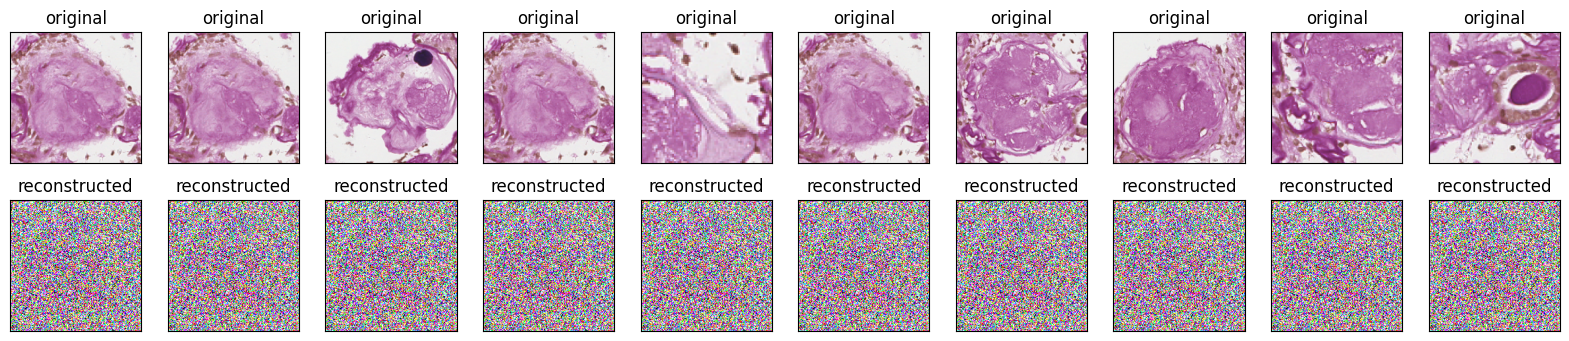

In [61]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(result[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()